<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [205]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [206]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [207]:
file = 'C:\\Users\\conte\\OneDrive\\Escritorio\\Secretaria Energia\\SARIMA\\TD_S_SescoWebUP_07_2022.csv'
datos = pd.read_csv(file, usecols=['Date','TotalPet'])
datos


,Date,TotalPet
0,1/1/2009,97924.5991
1,2/1/2009,100044.0659
2,3/1/2009,99329.5204
3,4/1/2009,98880.3859
4,5/1/2009,98151.9991
...,...,...
158,3/1/2022,89459.4248
159,4/1/2022,90490.6676
160,5/1/2022,91589.1089
161,6/1/2022,91155.8765


In [208]:
datos["Date"] = pd.to_datetime(datos["Date"])

datos = datos.set_index('Date')


In [209]:
datos['1000TotalPet'] = datos['TotalPet']/1000

In [210]:
datos.describe()

,TotalPet,1000TotalPet
count,163.000000,163.000000
mean,84443.916705,84.443917
std,6495.752824,6.495753
min,71163.538400,71.163538
25%,79468.451400,79.468451
50%,84406.510100,84.406510
75%,88486.056450,88.486056
max,100044.065900,100.044066


In [211]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [212]:
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq=None)

In [213]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

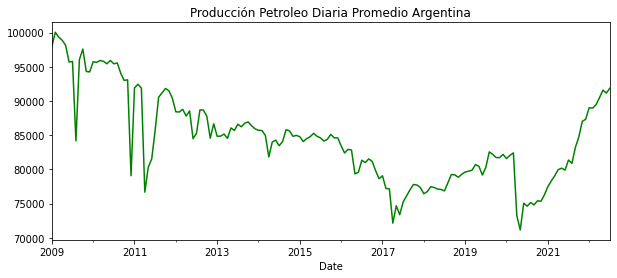

In [214]:
datos['TotalPet'].plot(figsize=(10,4), title='Producción Petroleo Diaria Promedio Argentina', color='green')
plt.show()

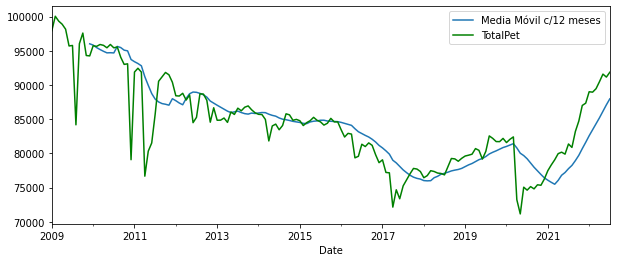

In [215]:
datos['TotalPet'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['TotalPet'].plot(color='green')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

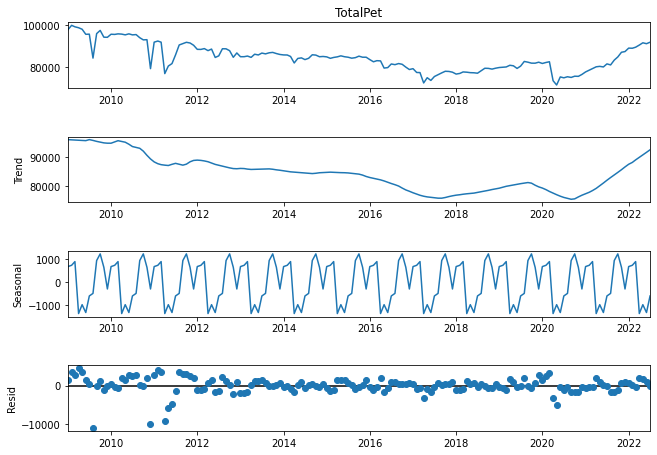

In [216]:
decomp = seasonal_decompose(datos['TotalPet'], period=12, extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [217]:
pValue = adfuller(datos['TotalPet'])[1]
pValue

0.16929624800270643

In [218]:
p_value_adfuller(datos['TotalPet'])

P-value:  0.16929624800270643
No se rechaza la hipóteis nula, los datos no son estacionarios


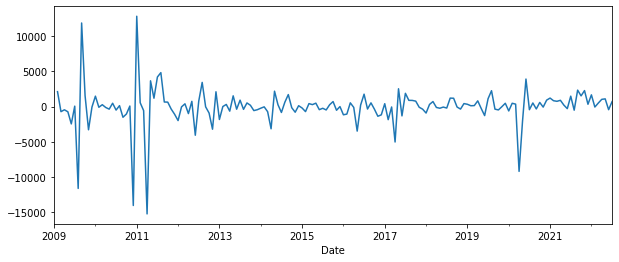

In [219]:
datos['1a diff']= datos['TotalPet'] - datos['TotalPet'].shift(1) 
datos['1a diff'].plot(figsize=(10,4))
plt.show()

In [220]:
p_value_adfuller((datos['1a diff']).dropna())

P-value:  1.2919028643504744e-18
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


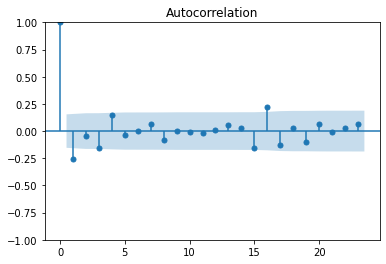

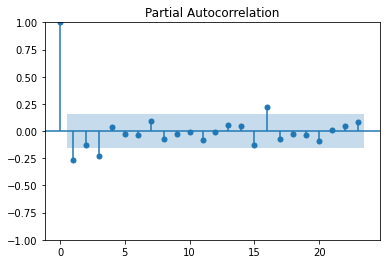

In [221]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [222]:
train = datos.loc[:'2022-1-1','TotalPet']
test = datos.loc['2022-1-1':,'TotalPet']

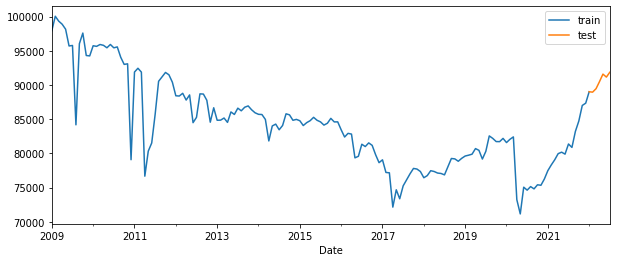

In [223]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [224]:
100*len(test)/len(train)

4.45859872611465

In [225]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [226]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [227]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2022-1-1','TotalPet'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit()#method_kwargs={"warn_convergence": False}
      aic_modelos[parametros, parametros_s] = results.aic
      # print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [239]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((2, 1, 0), (2, 2, 1, 12))
AIC:  1929.0757515705225


In [240]:
modelo = SARIMAX(datos['TotalPet'],
                       order = (2,1,0),
                       seasonal_order = (2,2,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1022      0.095     -1.081      0.280      -0.287       0.083
ar.L2         -0.0307      0.084     -0.364      0.716      -0.196       0.135
ar.S.L12      -0.2662      0.167     -1.597      0.110      -0.593       0.061
ar.S.L24      -0.2186      0.090     -2.438      0.015      -0.394      -0.043
ma.S.L12      -1.1773      0.246     -4.786      0.000      -1.659      -0.695
ma.S.L24       0.1468      0.177      0.831      0.406      -0.199       0.493
sigma2      3.912e+06   1.05e-07   3.72e+13      0.000    3.91e+06    3.91e+06


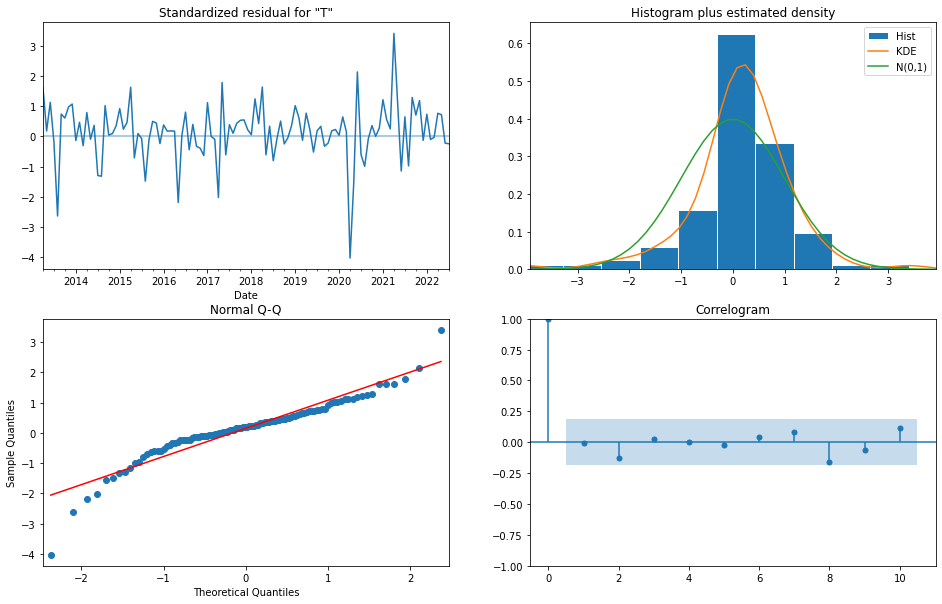

In [241]:
resultados.plot_diagnostics(figsize = (16,10))
plt.show()

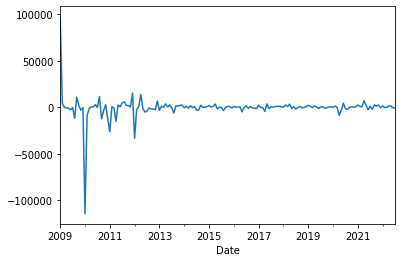

In [242]:
resultados.resid.plot()
plt.show()

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


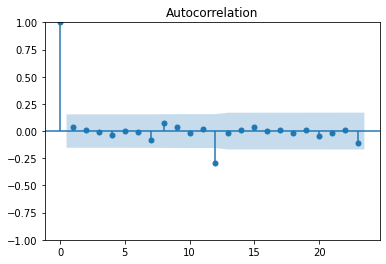

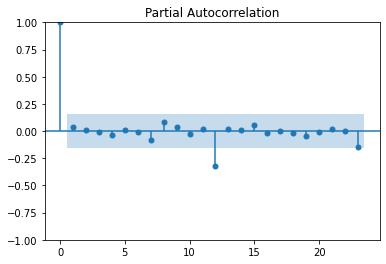

In [243]:
plot_acf(resultados.resid)
plot_pacf(resultados.resid)
plt.show()

# Validación

In [244]:
pred = resultados.get_prediction(start=pd.to_datetime('2022-01-01'),
                                 end=pd.to_datetime('2025-01-01'))
pred.predicted_mean

2022-01-01     87479.745211
2022-02-01     89171.074055
2022-03-01     89534.606721
2022-04-01     88895.393850
2022-05-01     90090.128492
2022-06-01     91626.146677
2022-07-01     92385.909763
2022-08-01     92819.403925
2022-09-01     93765.441033
2022-10-01     94717.349065
2022-11-01     96368.555806
2022-12-01     96962.212234
2023-01-01     97558.515599
2023-02-01     97429.696480
2023-03-01     97953.891195
2023-04-01     96584.377444
2023-05-01     96832.581759
2023-06-01     97558.474908
2023-07-01     98182.787937
2023-08-01     99425.386792
2023-09-01     99847.954077
2023-10-01    100820.994129
2023-11-01    102409.202788
2023-12-01    103190.659963
2024-01-01    103618.002433
2024-02-01    103428.044089
2024-03-01    104030.244734
2024-04-01    103317.736199
2024-05-01    103660.161731
2024-06-01    104227.174267
2024-07-01    105106.812858
2024-08-01    106416.344423
2024-09-01    106972.747455
2024-10-01    108136.968384
2024-11-01    110161.248171
2024-12-01    110964

In [245]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower TotalPet,upper TotalPet
2022-01-01,83361.989254,91597.501168
2022-02-01,85052.351220,93289.796891
2022-03-01,85423.097612,93646.115830
2022-04-01,84783.891975,93006.895726
2022-05-01,85978.627023,94201.629960
2022-06-01,87514.645211,95737.648142
2022-07-01,88274.408298,96497.411229
2022-08-01,88707.902459,96930.905390
2022-09-01,88239.065802,99291.816265
2022-10-01,88116.629060,101318.069070


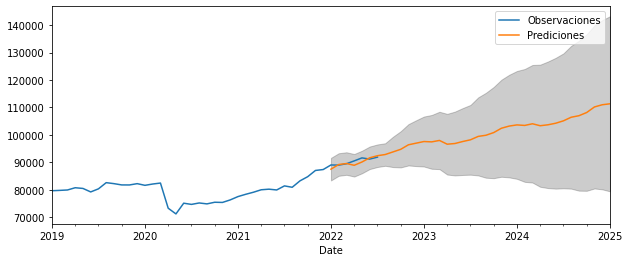

In [246]:
fig = datos.loc['2019-01-01':,'TotalPet'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

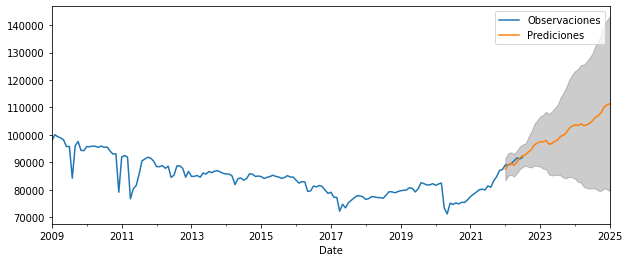

In [247]:
fig = datos.loc['2009-01-01':,'TotalPet'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [248]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2022-01-01':'2025-01-01','TotalPet']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 1098049.71
La raiz del error cuadrático medio es 1047.88


In [249]:
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(datos['TotalPet'].mean()), 3)} %")

Porcentaje de error con respecto al promedio: 1.241 %
